This notebook will run MHI with decay specified in config, with transforms on 
- MobileNet
- Resnet50
- EfficientNetB0

Dataset is 100 samples.<br>
DECAY = 0.09<br>
FRAME_SIZE = 20<br>
BINARY_THRESHOLD = 25

In [1]:
!pip install opencv-python numpy tensorflow scikit-learn matplotlib wandb tdqm wurlitzer albumentations seaborn

# Config

In [1]:
#all the required dependencies of the project
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns 
import time
import random
import wandb
import pandas as pd

from typing import Tuple
from collections import Counter
import albumentations as A
from tqdm import tqdm
from typing import List
import json
import tensorflow.keras as keras 
import tensorflow as tf

In [2]:
class CONFIG:
    ROOT_DIRECTORY = os.path.join("..","data","WLASL")
    JSON_FILE = "WLASL_v0.3.json"
    NSLT_FILE = "nslt_100.json"
    VIDEO_FOLDER = "videos"

    mean=[0, 0, 0]
    std=[1, 1, 1]
    DEBUG = True
    
    P_OF_TRANSFORM = 0.8
    P_OF_TRANSFORM_COLOR = 0.2
    
    SHIFT_LIMIT=0.1
    SCALE_LIMIT=0.05
    ROTATE_LIMIT=10
    
    # set to small, when prototyping, or 0 when deploying to cloud or PC with loads of RAM
    DATA_LIMIT = 100
    FRAME_SIZE = 10
    
    BATCH_SIZE = 4
    PORTION_OF_DATA_FOR_TRAINING = 0.8

    ROUND_DIGIT = 3
    #WANDB_RUN = "mediapipe-asl-dataset"
    
    USE_WANDB = True

    WANDB_RUN = "2SUM-CNN"

## Utils

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
from wandb.keras import WandbMetricsLogger
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, run_name : str,
                train_ds, val_ds, dataset_name,
                max_lr = 1e-4, min_lr = 5e-5,
                T_max=50, epochs=100,
                decay = 0.09,USE_WANDB=True): 
   
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)

    callbacks = [checkpoint ]#, cosine_annealer]

    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : min_lr, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : train_ds_len,
                                "val_size" : val_ds_len,
                                "unique_classes" : unique_labels_num, 
                                "video_length" : CONFIG.FRAME_SIZE,
                                "decay" : decay,
                                "SHIFT_LIMIT" : CONFIG.SHIFT_LIMIT,
                                "SCALE_LIMIT" : CONFIG.SCALE_LIMIT,
                                "ROTATE_LIMIT" : CONFIG.ROTATE_LIMIT,
                                "CACHEING" : dataset_name
                               })
        callbacks.append(WandbMetricsLogger())
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)
    #lr_metric = get_lr_metric(adam_optimizer)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    #history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, batch_size = 8, callbacks=[WandbMetricsLogger(), checkpoint, cosine_annealer])
    history = model.fit(train_ds, epochs=epochs, validation_data = val_ds, batch_size = CONFIG.BATCH_SIZE, callbacks=callbacks)
    #wandb.finish()
    if USE_WANDB:      
        wandb.finish()
    
    return history

# Cacheing Dataset definition

## Dataset definitions

In [63]:
def frame_diff2(prev, curr, kernel=np.array((5, 5), dtype=np.uint8),
                filter_size=3, filter_size_post=3, blocksize=15, C=3):
    frame_diff = cv2.subtract(curr, prev)
    frame_diff = cv2.medianBlur(frame_diff, filter_size)
    mask = cv2.adaptiveThreshold(frame_diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, blocksize, C)
    mask = cv2.medianBlur(mask, filter_size_post)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    return mask

def pseudocolor_generator(X, v1, v2, v3, v1_node, v2_node, v3_node, pow=1):
    I = X.astype(float) / 255.

    s1 = np.clip(1 - ((1. / ((v1_node - v1) ** 2)) * (v1 - I) ** 2) ** pow, 0, 1)
    s2 = np.clip(1 - ((1. / ((v2_node - v2) ** 2)) * (v2 - I) ** 2) ** pow, 0, 1)
    s3 = np.clip(1 - ((1. / ((v3_node - v3) ** 2)) * (v3 - I) ** 2) ** pow, 0, 1)

    return np.stack([s1, s2, s3], axis=2)


def MHI_1(prev_mhi, frame_diff, tau=255, delta=32):
    next_MHI = np.zeros_like(prev_mhi).astype(int)

    next_MHI[frame_diff == 255] = tau
    next_MHI[frame_diff != 255] = np.clip(prev_mhi[frame_diff != 255].astype(int) - delta, 0, 255)

    return np.clip(next_MHI, 0, 255).astype(np.uint8)

from sklearn.model_selection import train_test_split
from math import ceil


class SignRecognitionDataset(keras.utils.Sequence):

    def __init__(self, max_start : int, max_end) -> None:
        # setup the paths
        video_path = os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.VIDEO_FOLDER)
        dataset_description = os.path.join(CONFIG.ROOT_DIRECTORY)

        # load the filepaths for videos
        self.video_paths = [os.path.join(video_path, file) for file in os.listdir(video_path)]

        # load the dataset config json
        self.config_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.JSON_FILE)) as f:
            self.config_json = json.load(f)

        # load the dataset json
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f)
        
        self.videos_paths = []
        self.paths_not_found = []
        self.labels = []
        self.start_frames = []
        self.end_frames = []
       
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f) 

        for el in tqdm(self.dataset_json.items()):
            video_id, properties = el[0], el[1]
            path = os.path.join(video_path, video_id + ".mp4")
            
            if not os.path.exists(path):
                self.paths_not_found.append(path)
                continue

            subset = properties["subset"]
            label, start, end = properties["action"]
            
            if start > max_start:
                continue
                
            if end > max_end:
                continue
            
            self.videos_paths.append(path)
            self.labels.append(label)
            self.start_frames.append(start)
            self.end_frames.append(end)
    
        self.videos_paths = np.array(self.video_paths)
        self.paths_not_found = np.array(self.paths_not_found)
        self.labels = np.array(self.labels)
        self.start_frames = np.array(self.start_frames)
        self.end_frames = np.array(self.end_frames)

        self.unique_labels = np.unique(self.labels)
        
    
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return traj
    
    def __len__(self):
        return len(self.videos_paths)

    def __getitem__(self, idx):
        path, label = self.videos_paths[idx], self.labels[idx]
        trajectory = SignRecognitionDataset.get_video(path)
        
        return self.preprocess_trajectory(trajectory), label

    def permutate(self):
        l = len(self.videos_paths)
        mask = np.arange(l)
        np.random.shuffle(mask)
        
        self.videos_paths = np.array(self.videos_paths)[mask]
        self.labels = np.array(self.labels)[mask]
        self.start_frames = np.array(self.start_frames)[mask]
        self.end_frames = np.array(self.end_frames)[mask]
        
    def sort_by_size(self):
        c = Counter(self.labels)
        _mask = sorted([ (10000 * c[l] + l, i) for i, l in enumerate(self.labels)])[::-1]
        mask_by_size = np.array([el[1] for el in _mask])

        self.video_paths        = np.array(self.video_paths)[mask_by_size]
        self.labels             = np.array(self.labels)[mask_by_size]
        self.start_frames       = np.array(self.start_frames)[mask_by_size]
        self.end_frames         = np.array(self.end_frames)[mask_by_size]

    def crop_video(self, trajectory : np.array) -> np.array:
        cropped = trajectory
        
        if self.FRAME_SIZE != 0:
            frame_size = len(trajectory)
            start = 0 
            
            if frame_size > self.FRAME_SIZE:
                start = np.random.randint(0, frame_size - self.FRAME_SIZE)
            cropped = trajectory[start: (start + self.FRAME_SIZE)]
                    
            if len(cropped) < self.FRAME_SIZE:
                necessary = self.FRAME_SIZE - len(cropped)
                t, h, w, c = trajectory.shape
                cropped = np.concatenate([cropped, np.zeros((necessary, h, w, c))], axis= 0)
                
            return cropped
                        
        return trajectory
                
    @staticmethod
    def get_video(video_path : str) -> List[np.ndarray]:

        if not os.path.exists(video_path):
            return None

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None

        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame_array = np.array(frame)
                frames.append(cv2.cvtColor(frame_array, cv2.COLOR_BGR2RGB))
            else:
                break

        cap.release()
        return np.array(frames)

    @staticmethod
    def rescale_video(frames : np.ndarray, desired_shape) -> np.ndarray:
        refined = []
        for img in frames: 
            y, x, c = img.shape
            cropped = img[:, (x // 2 - y//2) : (x // 2 + y//2), :]
            scaled = cv2.resize(cropped, desired_shape)
            refined.append(scaled)
    
        return np.array(refined)

class SignRecognitionDatasetMHICachedV2TwoSum(SignRecognitionDataset):

    def __init__(self, max_start: int, max_end, 
                 per_image_transform=None,
                 after_MHI_transform=None,
                 scaled_resolution : Tuple[int]= (224, 224),
                 frame_size:int=CONFIG.FRAME_SIZE,
                 data_limit : int = CONFIG.DATA_LIMIT,
                 decay : float = 0.7,
                 method : str = "concat",
                 v1 : float = 1/3, v2 : float = 2/3, v3 : float = 1,
                 v1_node :float = 0, v2_node : float = 1, v3_node : float = 0.5, 
                 pow : float = 1,
                 by_size=True,
                 delta:int=32,
                 tau:int=255,
                 train_val_split:float=CONFIG.PORTION_OF_DATA_FOR_TRAINING,
                 split:str="train") -> None:
        super().__init__(max_start, max_end)
        self.scaled_resolution = scaled_resolution
        self.DATA_LIMIT = data_limit
        self.by_size = by_size
        self.per_image_transform = per_image_transform
        self.after_MHI_transform = after_MHI_transform
        self.FRAME_SIZE = frame_size + 1 # accounting for one extra frame because we are taking a derivative
        self.decay = decay
        self.delta = delta
        self.tau = tau
        self.method = method
        self.v1 = v1
        self.v2 = v2
        self.v3 = v3
        self.v1_node = v1_node
        self.v2_node = v2_node
        self.v3_node = v3_node
        self.pow = pow
        
        self.keywords = ["image" ] + list(str(i) for i in range(frame_size-1))
        
        self.sort_by_size()
        
        if self.DATA_LIMIT > 0:
            self.video_paths        = self.video_paths[:self.DATA_LIMIT]
            self.labels             = self.labels[:self.DATA_LIMIT]
            self.start_frames       = self.start_frames[:self.DATA_LIMIT]
            self.end_frames         = self.end_frames[:self.DATA_LIMIT]
        

        self.dataset = np.concatenate([np.array(self.video_paths).reshape(-1, 1),
                                       np.array(self.labels).reshape(-1, 1)], axis=1)   
        
        self.unique_labels = np.unique(self.dataset[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
        train_ds, val_ds = train_test_split(self.dataset, train_size=train_val_split, 
                                            random_state=42, stratify=self.dataset[:, 1])
                                                            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds
        
        else: 
            raise Exception("")

        self.cache_data()

    
    def cache_data(self):    
        self.cached_X = []
        self.cached_Y = []
        
        for i,(path, label) in tqdm(enumerate(self.dataset), desc="Cacheing"):
            trajectory = self.preprocess_trajectory(SignRecognitionDataset.get_video(path))  
            
            X_trajectory = []
            
            trajectory_length = trajectory.shape[0]
            if trajectory_length < self.FRAME_SIZE:
                X_trajectory.append(self.postprocess_trajectory(trajectory))

            else:
                for i in range(0, trajectory_length - self.FRAME_SIZE):
                    X_trajectory.append(self.postprocess_trajectory(trajectory[i: (i + self.FRAME_SIZE)]))
            
            onehotencoded = np.zeros(len(self.unique_labels))
            onehotencoded[self.label_2_id[label]] = 1.0
            
            for frame in X_trajectory:                    
                self.cached_X.append(frame)
                self.cached_Y.append(onehotencoded)
        
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return SignRecognitionDataset.rescale_video(traj, self.scaled_resolution)
        
    def __len__(self):
        return len(self.cached_X)

    def postprocess_trajectory(self, traj : np.ndarray) -> np.ndarray:
        ret = []
        
        # timeframe, Width, height, channels
        ts, w, h, c = traj.shape
                        
        prev = np.zeros(shape=(w, h))
        mhi = None
        
        for i in range(1, ts):
        
            _prev = cv2.cvtColor(traj[i-1], cv2.COLOR_BGR2GRAY)
            _curr = cv2.cvtColor(traj[i], cv2.COLOR_BGR2GRAY)
            
            fd = frame_diff2(prev=_prev,curr=_curr)
            mhi = MHI_1(prev, fd, tau=self.tau, delta=self.delta)
  
            val = fd.astype(float) / 255.
            
            rows = np.sum(val, axis=0) / val.shape[0]
            cols = np.sum(val, axis=1) / val.shape[1]
            
            if self.method.lower() == "concat":
                ret.append(np.concatenate([ rows, cols]))    
            elif self.method.lower() == "3d" or self.method.lower() == "2stream":
                ret.append(np.concatenate([ rows[..., np.newaxis], cols[..., np.newaxis]], axis= len(rows.shape) ))
                
            else:
                raise Exception("method parameter from __init__ should be either ['concat', '3d', '2stream']")
            prev = mhi
            

        return np.array(ret)


    def __getitem__(self, idx):
        
        trajectory, label = self.cached_X[idx], self.cached_Y[idx]
        
        if self.method == "concat":            
            if self.per_image_transform is not None:
                trajectory = self.per_image_transform(image=trajectory)["image"]
            return trajectory, label
        
        elif self.method == "2stream":
            sh = trajectory.shape
            rows, cols = trajectory[:, : , 0], trajectory[:, :, 1]
                
            return (rows, cols), label

# Training

## Concatenation Dataset

### Dataset creation

In [64]:
transform = A.Compose(
    [
        #A.HorizontalFlip(p=CONFIG.P_OF_TRANSFORM),
        #A.ShiftScaleRotate(p=CONFIG.P_OF_TRANSFORM, shift_limit=CONFIG.SHIFT_LIMIT, 
        #                   scale_limit=CONFIG.SCALE_LIMIT, rotate_limit=CONFIG.ROTATE_LIMIT),
        #A.RandomBrightnessContrast(p=CONFIG.P_OF_TRANSFORM_COLOR),
        #A.RGBShift(p=CONFIG.P_OF_TRANSFORM_COLOR),
    ]
)

train_ds = SignRecognitionDatasetMHICachedV2TwoSum(1, 70, per_image_transform=None,
                                                        method="concat",
                                                        split="train")
val_ds   = SignRecognitionDatasetMHICachedV2TwoSum(1, 70, per_image_transform=None,
                                                        method="concat",
                                                        split="val")

train_ds_len, val_ds_len, unique_labels_num = len(train_ds), len(val_ds), len(train_ds.unique_labels)
x, y = next(iter(train_ds))
x_shape, y_shape = x.shape, y.shape

print(f"size of train_ds = {len(train_ds)}, size of val_ds = {len(val_ds)}")
print(x_shape, y_shape)

100%|██████████| 2038/2038 [00:00<00:00, 40593.96it/s]
Cacheing: 80it [01:47,  1.35s/it]
100%|██████████| 2038/2038 [00:00<00:00, 47071.22it/s]
Cacheing: 20it [00:23,  1.20s/it]

size of train_ds = 4947, size of val_ds = 1489
(10, 448) (9,)


In [65]:
def dataset_train_generator():
    # Instantiate your existing dataset loader

    for i in range(len(train_ds)):
        X_batch, Y_batch = train_ds[i]
        yield X_batch, Y_batch
        
def dataset_val_generator():
    # Instantiate your existing dataset loader

    for i in range(len(val_ds)):
        X_batch, Y_batch = val_ds[i]
        yield X_batch, Y_batch        

train_dataset = tf.data.Dataset.from_generator(lambda: dataset_train_generator(),
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=(x_shape, y_shape)).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(lambda: dataset_val_generator(),
                                             output_types=(tf.float32, tf.float32),    
                                             output_shapes=(x_shape, y_shape)).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


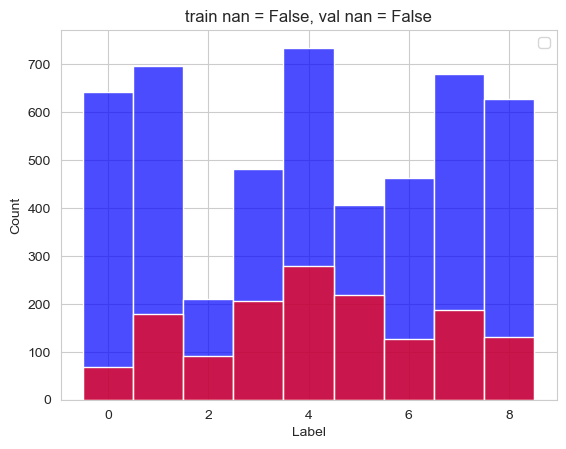

In [66]:
def check_dataset(_train_ds, _val_ds):

    nans_train = False
    train_labels = []
    val_labels = []

    for x, y in _train_ds:
        labels = np.argmax(y, axis=1)
        for l in labels:
            train_labels.append(l)

        nans_train |= np.any(np.isnan(x))

    nans_val = False
    for x, y in val_dataset:
        labels = np.argmax(y, axis=1)
        for l in labels:
            val_labels.append(l)

        nans_val |= np.any(np.isnan(x))
    
    
    train_df_labels = pd.DataFrame(train_labels, columns=['Label'])
    val_df_labels = pd.DataFrame(val_labels, columns=['Label'])

    sns.histplot(train_df_labels, x="Label", alpha=0.7, discrete=True, kde=False, color="blue")
    sns.histplot(val_df_labels, x="Label", alpha=0.7,discrete=True, kde=False, color="red")
    plt.title(f"train nan = {nans_train}, val nan = {nans_val}")
    plt.legend()
    plt.show()

check_dataset(train_dataset, val_dataset)

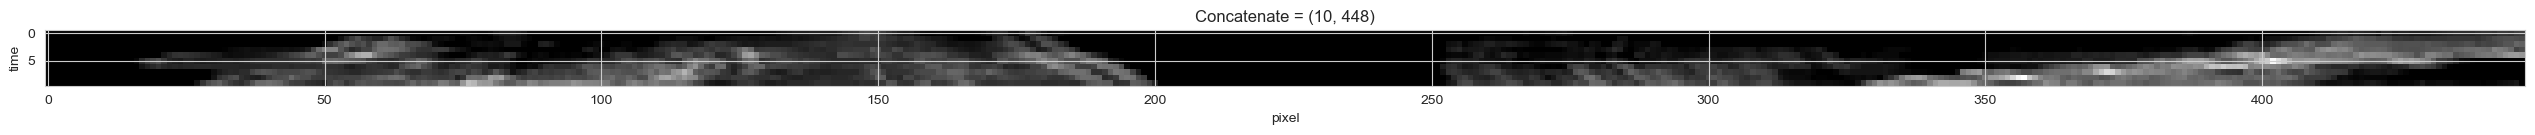

In [67]:
x, y = next(iter(train_ds))
x_shape, y_shape = x.shape, y.shape

plt.figure(figsize=(32, 16))
plt.imshow(x, cmap="gray")
plt.title(f"Concatenate = {x.shape}")
plt.xlabel("pixel")
plt.ylabel("time")
plt.savefig("plot.png")

## run the experiments

### Network V1

In [68]:
def residual_block(x, dil, filters, ks=3):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(bn1)
    conv1 = tf.keras.layers.Conv1D(filters, ks, dilation_rate=dil, padding="same")(a1)
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, ks, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    return x

In [69]:
residuals_filters = 64
residuals_ks = 3

input_x = tf.keras.Input(shape=x_shape)
x = tf.keras.layers.Conv1D(64, 8, padding="same")(input_x)
x = residual_block(x, 1, filters=residuals_filters, ks=residuals_ks)
x = residual_block(x, 1, filters=residuals_filters, ks=residuals_ks)
x = tf.keras.layers.Permute(dims=[2, 1])(x)
x = tf.keras.layers.Conv1D(64, 3, padding="same")(x)
x = residual_block(x, 1, residuals_filters, ks=residuals_ks)
x = residual_block(x, 2, residuals_filters, ks=residuals_ks)
x = tf.keras.layers.Lambda(lambda x: K.expand_dims(x, -1))(x) #will not compile if not defined as lambda
x = tf.keras.layers.Conv2D(32, (4,4), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(8, (8,8), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPooling2D((64,64))(x)
x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(y_shape[0], activation="softmax")(x)

model = tf.keras.Model(inputs=input_x, outputs=out)

model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 10, 448)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 10, 64)    │    229,440 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_106[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_87       │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 10, 64)    │     12,352 │ activation_87[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_107[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_88       │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_108 (Conv1D) │ (None, 10, 64)    │     12,352 │ activation_88[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 10, 64)    │          0 │ conv1d_108[0][0], │
│                     │                   │            │ conv1d_106[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ add_39[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_89       │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_109 (Conv1D) │ (None, 10, 64)    │     12,352 │ activation_89[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_109[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_90       │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_110 (Conv1D) │ (None, 10, 64)    │     12,352 │ activation_90[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 10, 64)    │          0 │ conv1d_110[0][0], │
│                     │                   │            │ add_39[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_18          │ (None, 64, 10)    │          0 │ add_40[0][0]      │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_111 (Conv1D) │ (None, 64, 64)    │      1,984 │ permute_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_111[0][0]

 Total params: 349,305 (1.33 MB)

 Trainable params: 348,281 (1.33 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [70]:
keras_train(model, run_name="two_sum", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="MHI-twosum-concat", 
            max_lr = 1e-4, 
            min_lr = 5e-5,
            T_max=21, 
            epochs=40,
            filepath=os.path.join("models", "C2_MobileNetV3Small_no_transforms.keras"), 
            USE_WANDB=False)

Epoch 1/40
   1237/Unknown 34s 19ms/step - categorical_accuracy: 0.1261 - loss: 2.3494

E:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1237/1237 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - categorical_accuracy: 0.1261 - loss: 2.3494 - val_categorical_accuracy: 0.0510 - val_loss: 2.1998
Epoch 2/40
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - categorical_accuracy: 0.0641 - loss: 2.1966 - val_categorical_accuracy: 0.0927 - val_loss: 2.1942
Epoch 3/40
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - categorical_accuracy: 0.1224 - loss: 2.1912 - val_categorical_accuracy: 0.0745 - val_loss: 2.1948
Epoch 4/40
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - categorical_accuracy: 0.1200 - loss: 2.1920 - val_categorical_accuracy: 0.0913 - val_loss: 2.1914
Epoch 5/40
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - categorical_accuracy: 0.1132 - loss: 2.1914 - val_categorical_accuracy: 0.1283 - val_loss: 2.1884
Epoch 6/40
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - categorical_accuracy: 0.1128 - loss: 2.1791 - val_categorical_accuracy: 0.1679 - val_loss: 2.1855
Epoch 7/40
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - categorical_accur

KeyboardInterrupt: 